# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Convering xml to csv: https://github.com/asetkn/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps/blob/master/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps.ipynb
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

#Preprocessing

### Imports
*Standard from Detectron2's docs*

In [1]:
#@title check gpu
!nvidia-smi

Mon Nov 29 23:38:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install dependencies: 
!pip install pyyaml==5.1
#!pip3 install torch torchvision torchaudio
!pip3 install torch==1.8.0+cu101 torchvision==0.9.0+cu101 torchaudio -f https://download.pytorch.org/whl/cu101/torch_stable.html
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 763.5 MB 16 kB/s 
     |████████████████████████████████| 17.3 MB 1.0 MB/s 
     |████████████████████████████████| 2.9 MB 7.6 MB/s 
     |████████████████████████████████| 1.9 MB 39.9 MB/s 
     |████████████████████████████████| 1.9 MB 42.3 MB/s 
     |████████████████████████████████| 1.9 MB 40.1 MB/s 
     |████████████████████████████████| 1.9 MB 45.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully unins

1.10.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [1]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


*Restart after executing this cell*

In [1]:
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import pickle
ia.seed(1)
%matplotlib inline



# Registering with Detectron2

---


According to https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts:

Each dict contains information about one image with the following fields:
  - file_name: the full path to the image file.
  - height, width: integer. The shape of the image.
  - image_id (str or int): a unique id that identifies this image. Required by many evaluators to identify the images, but a dataset may use it for different purposes.
  - annotations (list[dict]): Required by instance detection/segmentation or keypoint detection tasks. 
  Each dict corresponds to annotations of one instance in this image, and may contain the following keys:
      - bbox (list[float], required): list of 4 numbers representing the bounding box of the instance.
      - bbox_mode (int, required): the format of bbox. It must be a member of structures.BoxMode. Currently supports: BoxMode.XYXY_ABS, BoxMode.XYWH_ABS.
      - category_id (int, required): an integer in the range [0, num_categories-1] representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.
    

### Verification

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
# Global paths (Using SSDD default folder structure)
root = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/'
xml_path = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/Annotations_sub/'
jpg_path = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/JPEGImages_sub/'
dest = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/'
imagesets = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/ImageSets/Main/'

## Creating train, test, test_inshore, test_offshore folders
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:
# Already ran once
import shutil
os.mkdir(dest)
os.mkdir(dest + "train/")
os.mkdir(dest + "test/")
os.mkdir(dest + "test_offshore/")
os.mkdir(dest + "test_inshore/")


In [ ]:
os.mkdir(dest + "train/train_w_val/")
os.mkdir(dest + "train/validation/")
os.mkdir(dest + "train/toy/")

In [9]:
test = pd.read_csv(imagesets + 'test.txt', header = None, names = ['file'])
train = pd.read_csv(imagesets + 'train.txt', header = None, names = ['file'])
test_offshore = pd.read_csv(imagesets + 'test_offshore.txt', header = None, names = ['file'])
test_inshore = pd.read_csv(imagesets + 'test_inshore.txt', header = None, names = ['file'])

In [ ]:
# Already ran once
# Function that moves files from JPEG to dataset folder
def copyFiles(df, orig = None, dest = None):
  i = 0
  for index, rows in df.iterrows():
    i += 1
    if i % 100 == 0:
            print (i)
    shutil.copyfile(orig + rows['file'] + '.jpg',
                    dest + rows['file'] + '.jpg')  
  print("Moved " + str(i) + " files.")

In [ ]:
# Already ran once
# ONLY MEANT TO BE EXECUTED ONCE
# Move files to correct dataset path
copyFiles(test, jpg_path, dest + 'test/')
copyFiles(train, jpg_path, dest + 'train/')
copyFiles(test_offshore, jpg_path, dest + 'test_offshore/')
copyFiles(test_inshore, jpg_path, dest + 'test_inshore/')

## XML to CSV - Converts XML annotations to a CSV file
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:
# Function that will extract data from xml for our CSV file
def xml_to_csv(path):
  """Returns a pandas dataframe containing information from xml files in path"""
  xml_list = []
  for xml_file in glob.glob(path):
      tree = ET.parse(xml_file)
      root = tree.getroot()
      for member in root.findall('object'):
          value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[4][0].text),
                    int(member[4][1].text),
                    int(member[4][2].text),
                    int(member[4][3].text)
                    )
          xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  return xml_df

In [ ]:
# ONLY MEANT TO BE EXECUTED ONCE
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv(xml_path + '*.xml')
#labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')
labels_df.to_csv((root + 'labels.csv'), index=None)

## Verify Results

In [4]:
labels_df = pd.read_csv(root + 'labels.csv')
labels_df.shape

(6015, 8)

In [5]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename') # used later
image_name = '01_18_12'
# we can pull each group with get_group() using the filename
group_df = grouped.get_group(image_name + '.xml')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_18_12.xml,800,800,ship,624,1,654,23
1,01_18_12.xml,800,800,ship,598,76,609,94
2,01_18_12.xml,800,800,ship,632,63,650,92
3,01_18_12.xml,800,800,ship,735,63,747,79
4,01_18_12.xml,800,800,ship,215,180,230,194


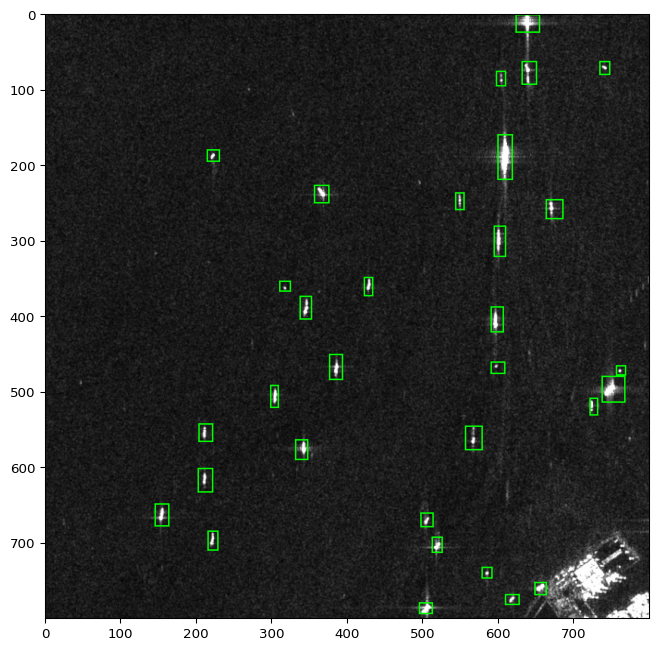

In [6]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread(jpg_path + image_name + '.jpg')
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes
ia.imshow(bbs.draw_on_image(image, size=2))

## Conversion to Detectron2's Standard Dataset Dicts



In [7]:
# Function that converts annotations to Detectron's format
# and then saves a pickle output to path
def standardize(path, annotations, df, grouped):
  anns_id = [i.split('.')[0] for i  in annotations]
  anns_df = pd.DataFrame(anns_id, columns=['file'])
  # Attach correct image file path
  anns_df = df.merge(df, 
                     on = 'file',  
                     how = 'inner')
  # Give default values
  std = {i: {
        "file_name": df.loc[df['file'] == i]['type'].values[0] + i +'.jpg',
        "height": 800, # All images of the same dimension
        "width": 800, # All images of the same dimension
        "image_id": i,
        "annotations": []
        } for i in df['file'].values
      }
  # Overwrite files with correct annotations
  keys = grouped.groups.keys()
  for i in keys:
    if i.split('.')[0] in std:
      j = grouped.get_group(i)
      temp = []
      for index, row in j.iterrows():
        ann_temp = {
            'bbox' : [
                      row['xmin'],  
                      row['ymin'],  
                      row['xmax'],  
                      row['ymax']
                      ],
            'bbox_mode': BoxMode.XYXY_ABS,
            'category_id': 0
        }
        temp.append(ann_temp)
      std[i.split('.')[0]]['annotations'] = temp
  # Cache
  f = open(path + "standardDict.pkl","wb")
  pickle.dump(list(std.values()),f)
  f.close()
  return std

In [10]:
# Add path to datasets
test['type'] = dest + 'test/'
train['type'] = dest + 'train/'
test_offshore['type'] = dest + 'test_offshore/'
test_inshore['type'] = dest + 'test_inshore/'
# All xml annotations
anns = os.listdir(xml_path)

In [11]:
# Make standardized annotations
test_std = standardize(dest + 'test/', anns, test, grouped)
train_std = standardize(dest + 'train/', anns, train, grouped)
test_o_std = standardize(dest + 'test_offshore/', anns, test_offshore, grouped)
test_i_std = standardize(dest + 'test_inshore/', anns, test_inshore, grouped)

In [12]:
# Verification
assert(len(test_std) + len(train_std) == len(anns))
assert((len(test_std) == len(test_o_std) + len(test_i_std)))
train_std['01_18_12']

{'annotations': [{'bbox': [624, 1, 654, 23],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [598, 76, 609, 94],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [632, 63, 650, 92],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [735, 63, 747, 79],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [215, 180, 230, 194],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [357, 227, 375, 249],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [544, 237, 554, 258],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [600, 160, 618, 218],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [664, 246, 685, 270],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [311, 354, 324, 366],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [338, 374, 352, 403],
   'bbox_mode': <BoxM

In [13]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

## Split Train into Train and Validation Sets

### Validation Set

In [14]:
train = get_dict('train')

In [15]:
k = int(len(train) * 0.15)
print(k)

900


In [16]:
import random
random.seed(1)
total_idx = list(range(len(train)))
val_idx = random.sample(total_idx, k = k)

In [17]:
train_idx = set(total_idx) - set(val_idx)

In [18]:
len(train_idx)

5100

In [19]:
assert [i for i in val_idx if i in train_idx] == []


In [20]:
train_with_val = [train[i] for i in train_idx]
validation = [train[i] for i in val_idx]

In [21]:
print(len(train_with_val))
print(len(validation))

5100
900


In [22]:
f = open(dest + 'train/train_w_val/' + "standardDict.pkl","wb")
pickle.dump(list(train_with_val),f)
f.close()

f = open(dest + 'train/validation/' + "standardDict.pkl","wb")
pickle.dump(list(validation),f)
f.close()

### Toy Dataset

In [23]:
toy_idx = random.sample(train_idx, k = 100)
len(toy_idx)

100

In [24]:
toy = [train[i] for i in toy_idx]

In [25]:
f = open(dest + 'train/toy/' + "standardDict.pkl","wb")
pickle.dump(list(toy),f)
f.close()

## Verification

In [26]:
datasets = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/'

In [27]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/Fall_2021/CS682/Project/682_Project/SSDDShipDetection/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [28]:
from detectron2.structures import BoxMode

for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
   # DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])
train_metadata = MetadataCatalog.get('train')
train_metadata

Metadata(name='train', thing_classes=['ship'])

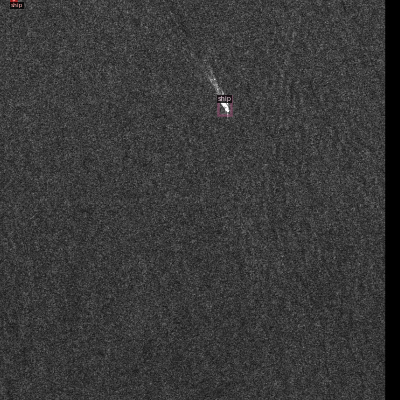

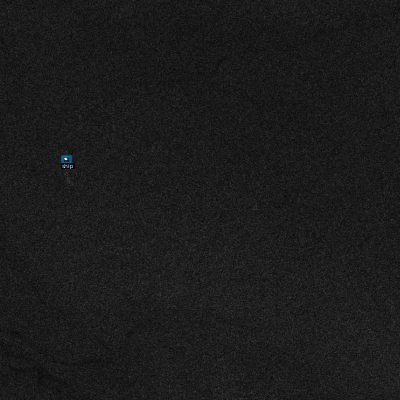

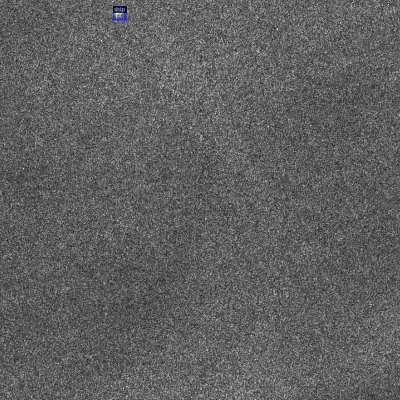

In [29]:
dataset_dicts = get_dict("train/train_w_val")

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

#random.seed(6)
for d in random.sample(dataset_dicts_anns, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])